In [ ]:
import numpy as np
import pandas as pd
import sqlite3
import csv
import calendar
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from linearmodels.panel import PanelOLS
from linearmodels.panel import FirstDifferenceOLS
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt

In [ ]:
##Import State Level Monthly End R0 Value
rt_state = pd.read_csv("rt.csv", header=0)
rt_state = rt_state.replace({'date': "2021-01-26"}, "2021-01-31")
rt_state.date = pd.to_datetime(rt_state.date)
rt_state["month_year"] = pd.to_datetime(rt_state.date).dt.to_period('M').astype(str)
rt_state['month'] = rt_state['month_year'].apply(lambda x: calendar.month_abbr[int(x[-2:])])
rt_state['year'] = rt_state['month_year'].apply(lambda x: str(x[2:-3]))
rt_state["month_year"] = rt_state.month + "-" + rt_state.year
rt_state = rt_state[rt_state.date.dt.is_month_end].reset_index()
rt_state = rt_state[["date", "region", "mean", "median", "month_year"]].rename(columns={"date": "Rt_date", "region": "state_cd", "mean": "Rt_mean", "median": "Rt_median", "month_year": "Rt_month"})

In [ ]:
##Import State Level Monthly End Real Estate Price
raw_re = pd.read_csv("State_Real_Estate2020.csv", header=0)
raw_re = raw_re[["RegionID", "RegionName", "StateName", "1/31/2020", "2/29/2020", "3/31/2020","4/30/2020","5/31/2020","6/30/2020","7/31/2020","8/31/2020","9/30/2020","10/31/2020","11/30/2020","12/31/2020","1/31/2021","2/28/2021"]]
lst=["2/29/2020","3/31/2020", "4/30/2020","5/31/2020","6/30/2020","7/31/2020","8/31/2020","9/30/2020","10/31/2020","11/30/2020","12/31/2020","1/31/2021","2/28/2021"]

real_estate_state = raw_re[["RegionID", "RegionName", "StateName", "1/31/2020"]].rename(columns={"1/31/2020": "Re_price"})
real_estate_state["Re_date"]="1/31/2020"
for x in lst:
    tmp1=raw_re[["RegionID", "RegionName", "StateName", x]].rename(columns={x: "Re_price"})
    tmp1["Re_date"]=x
    real_estate_state=pd.concat([real_estate_state,tmp1])

real_estate_state.Re_date = pd.to_datetime(real_estate_state.Re_date)
real_estate_state["Re_month"] = pd.to_datetime(real_estate_state.Re_date).dt.to_period('M').astype(str)
real_estate_state['month'] = real_estate_state['Re_month'].apply(lambda x: calendar.month_abbr[int(x[-2:])])
real_estate_state['year'] = real_estate_state['Re_month'].apply(lambda x: str(x[2:-3]))
real_estate_state["Re_month"] = real_estate_state.month + "-" + real_estate_state.year
real_estate_state=real_estate_state.reset_index().drop(columns=['index','month','year']).rename(columns={"RegionName":"state","StateName":"state_cd"})

In [4]:
##Import State Level Monthly End CPI
state_region = pd.read_csv("State_Region.csv", header=0)
region_CPI = pd.read_csv("Region_CPI.csv", header=0)
CPI_state=state_region.merge(region_CPI,on='Region2',how='inner').drop(columns=["Region1_x","Region1_y","Region2","1-month","12-month"]).rename(columns={"State":"state","Month":"month","1-month_perc":"CPI_1mo","12-month_perc":"CPI_12mo"})
CPI_state.CPI_1mo=CPI_state.CPI_1mo*100
CPI_state.CPI_12mo=CPI_state.CPI_12mo*100

In [5]:
##Import State Level Monthly End Unemployment Rate
ur_state2020=pd.read_csv("Unemployment 2020.csv", header=0)
ur_state2021=pd.read_csv("Unemployment rate 2021 1-3.csv", header=0)
raw_ur=ur_state2020.merge(ur_state2021,on='State',how='inner')
lst=['Feb-20','Mar-20','Apr-20','May-20','Jun-20','Jul-20','Aug-20','Sep-20','Oct-20','Nov-20','Dec-20','Jan-21','Feb-21','Mar-21']

ur_state=raw_ur[['State','Jan-20']].rename(columns={"Jan-20": "Unemploy_rate"})
ur_state["month"]='Jan-20'
for x in lst:
    tmp=raw_ur[['State',x]].rename(columns={x: "Unemploy_rate"})
    tmp["month"]=x
    ur_state=pd.concat([ur_state,tmp])
ur_state["Ur_rate"]=ur_state.Unemploy_rate
ur_state=ur_state.reset_index().drop(columns=['Unemploy_rate','index']).rename(columns={"State":"state"})

In [6]:
#Combine Dataframe
combine=pd.merge(real_estate_state,rt_state,how='outer',left_on=['state_cd','Re_month'],right_on=['state_cd','Rt_month']).drop(columns=['Rt_date','Rt_month']).rename(columns={"Re_month":"month",'Re_date':'date'})
combine=pd.merge(combine,CPI_state,how='inner',on=['state','month'])
combine=pd.merge(combine,ur_state,how='inner',on=['state','month'])
combine=combine[['RegionID','state_cd','state','month','date','Rt_mean','Rt_median','Re_price','CPI_1mo','CPI_12mo','Ur_rate']].sort_values(by=['state_cd','date'], ascending=True).reset_index().drop(columns='index')
combine.to_csv (r'combined_data_new.csv', index = False, header=True)
combine_feb21=combine[combine.month=='Feb-21']
combine=combine[combine.Rt_mean.notnull()]

In [7]:
#Create the Models
combine_new = combine.set_index(['state_cd','date'])
mod_Re_price_panel = PanelOLS(combine_new.Re_price, combine_new.Rt_mean, entity_effects=True)
res_Re_price_panel = mod_Re_price_panel.fit(cov_type='clustered', cluster_entity=True)
print(res_Re_price_panel)

                          PanelOLS Estimation Summary                           
Dep. Variable:               Re_price   R-squared:                        0.0888
Estimator:                   PanelOLS   R-squared (Between):             -0.0378
No. Observations:                 599   R-squared (Within):               0.0888
Date:                Fri, Apr 23 2021   R-squared (Overall):             -0.0377
Time:                        23:57:54   Log-likelihood                   -6208.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      53.322
Entities:                          51   P-value                           0.0000
Avg Obs:                       11.745   Distribution:                   F(1,547)
Min Obs:                       11.000                                           
Max Obs:                       13.000   F-statistic (robust):             50.344
                            

In [8]:
mod_CPI_1mo_panel = PanelOLS(combine_new.CPI_1mo, combine_new.Rt_mean, entity_effects=True)
res_CPI_1mo_panel = mod_CPI_1mo_panel.fit(cov_type='clustered', cluster_entity=True)
print(res_CPI_1mo_panel)

                          PanelOLS Estimation Summary                           
Dep. Variable:                CPI_1mo   R-squared:                        0.0125
Estimator:                   PanelOLS   R-squared (Between):              0.3951
No. Observations:                 599   R-squared (Within):               0.0125
Date:                Fri, Apr 23 2021   R-squared (Overall):              0.0352
Time:                        23:57:55   Log-likelihood                   -356.55
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.9425
Entities:                          51   P-value                           0.0087
Avg Obs:                       11.745   Distribution:                   F(1,547)
Min Obs:                       11.000                                           
Max Obs:                       13.000   F-statistic (robust):             59.405
                            

In [9]:
mod_CPI_12mo_panel = PanelOLS(combine_new.CPI_12mo, combine_new.Rt_mean, entity_effects=True)
res_CPI_12mo_panel = mod_CPI_12mo_panel.fit(cov_type='clustered', cluster_entity=True)
print(res_CPI_12mo_panel)

                          PanelOLS Estimation Summary                           
Dep. Variable:               CPI_12mo   R-squared:                        0.1903
Estimator:                   PanelOLS   R-squared (Between):              0.7803
No. Observations:                 599   R-squared (Within):               0.1903
Date:                Fri, Apr 23 2021   R-squared (Overall):              0.6543
Time:                        23:57:55   Log-likelihood                   -481.90
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      128.57
Entities:                          51   P-value                           0.0000
Avg Obs:                       11.745   Distribution:                   F(1,547)
Min Obs:                       11.000                                           
Max Obs:                       13.000   F-statistic (robust):             112.99
                            

In [10]:
mod_Ur_rate_panel = PanelOLS(combine_new.Ur_rate, combine_new.Rt_mean, entity_effects=True)
res_Ur_rate_panel = mod_Ur_rate_panel.fit(cov_type='clustered', cluster_entity=True)
print(res_Ur_rate_panel)

                          PanelOLS Estimation Summary                           
Dep. Variable:                Ur_rate   R-squared:                        0.1035
Estimator:                   PanelOLS   R-squared (Between):             -0.7722
No. Observations:                 599   R-squared (Within):               0.1035
Date:                Fri, Apr 23 2021   R-squared (Overall):             -0.6464
Time:                        23:57:55   Log-likelihood                   -1519.9
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      63.169
Entities:                          51   P-value                           0.0000
Avg Obs:                       11.745   Distribution:                   F(1,547)
Min Obs:                       11.000                                           
Max Obs:                       13.000   F-statistic (robust):             177.34
                            

In [11]:
#Perform individual linear regressions by each state
lst=combine.state_cd.unique()
data_by_state=[]
for x in lst:
    data_by_state.append(combine[combine.state_cd==x])
res_Re_price=[]
res_CPI_1mo=[]
res_CPI_12mo=[]
res_Ur_rate=[]
for z in data_by_state:
    Rt_mean=z.Rt_mean.values.reshape(-1,1)
    Re_price=z.Re_price.values.reshape(-1,1)
    CPI_1mo=z.CPI_1mo.values.reshape(-1,1)
    CPI_12mo=z.CPI_12mo.values.reshape(-1,1)
    Ur_rate=z.Ur_rate.values.reshape(-1,1)
    model1 = LinearRegression().fit(Rt_mean,Re_price)
    res_Re_price.append(model1)
    model2 = LinearRegression().fit(Rt_mean,CPI_12mo)
    res_CPI_12mo.append(model2)
    model3 = LinearRegression().fit(Rt_mean,Ur_rate)
    res_Ur_rate.append(model3)
    model4 = LinearRegression().fit(Rt_mean,CPI_1mo)
    res_CPI_1mo.append(model4)

In [12]:
rt_state = pd.read_csv("rt.csv", header=0)
rt_state.date = pd.to_datetime(rt_state.date)
rt_state=rt_state[['date','region','mean','median']].rename(columns={'region':'state_cd','mean':'Rt_mean','median':'Rt_median'}).sort_values(by=['state_cd','date'], ascending=True)
lst=rt_state.state_cd.unique()
rt_by_state=rt_state[rt_state.state_cd==lst[0]]
rt_by_state=rt_by_state[['date','Rt_mean']].rename(columns={"Rt_mean": lst[0]})
for x in lst:
    tmp=rt_state[rt_state.state_cd==x]
    tmp=tmp[['date','Rt_mean']].rename(columns={"Rt_mean": x})
    rt_by_state=rt_by_state.merge(tmp,on=['date'],how='outer')
rt_by_state=rt_by_state.rename(columns={'AK_x':'AK'}).sort_values(by=['date'], ascending=True).reset_index().drop(columns=['AK_y','index'])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

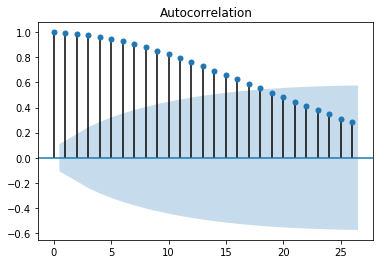

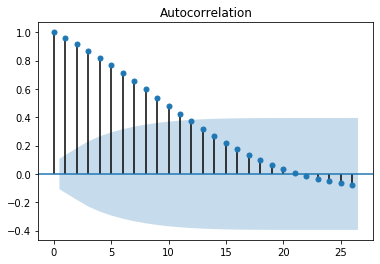

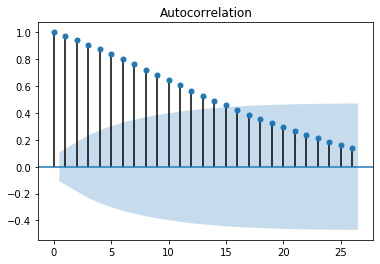

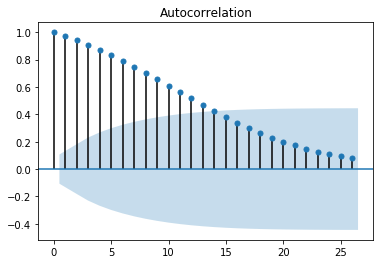

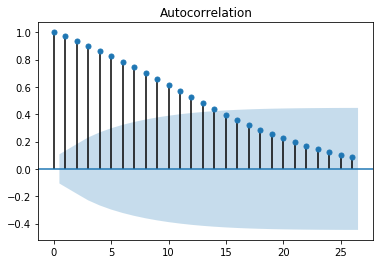

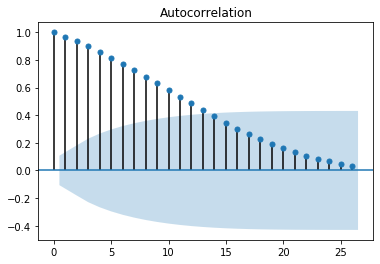

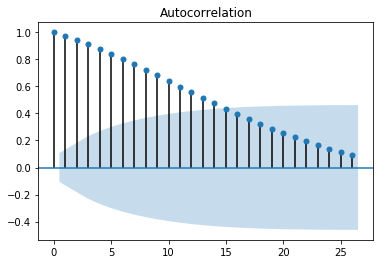

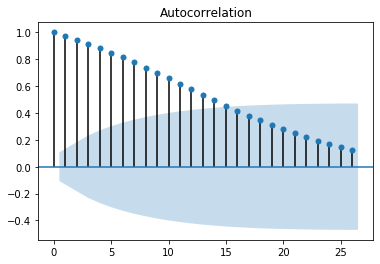

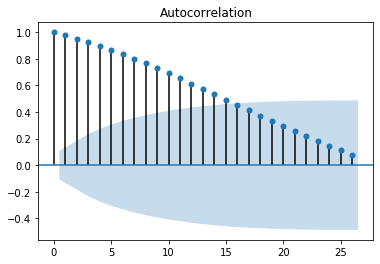

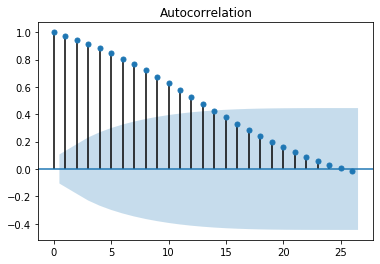

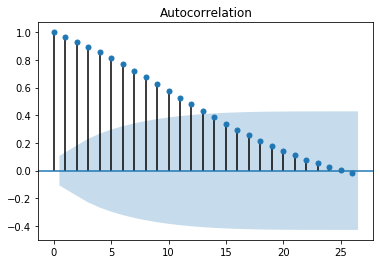

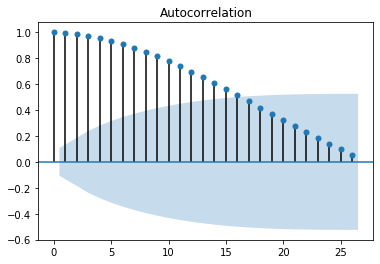

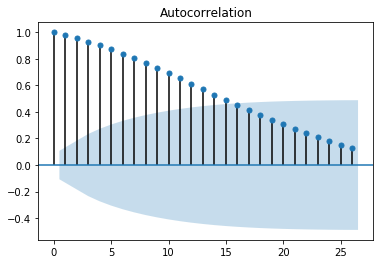

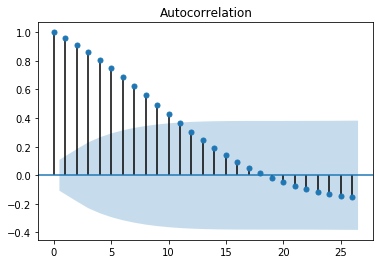

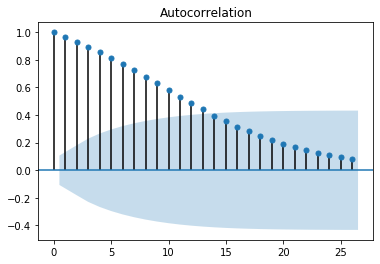

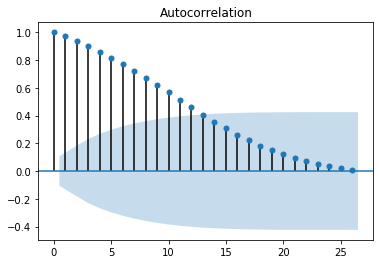

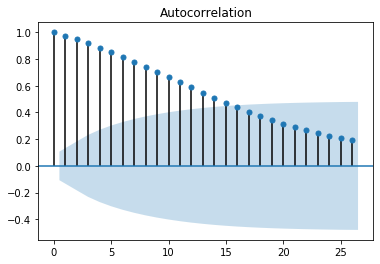

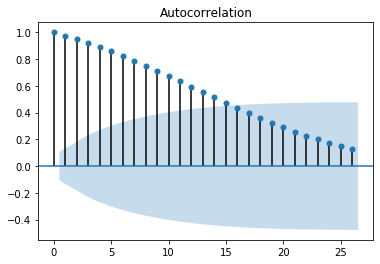

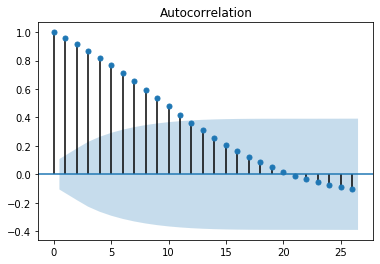

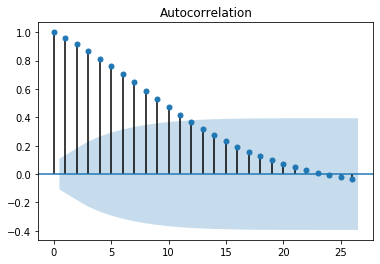

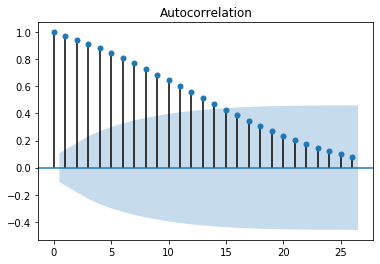

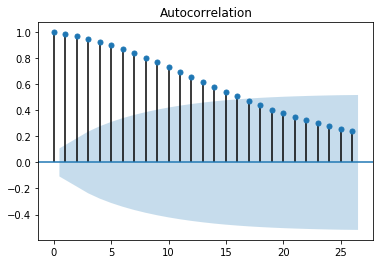

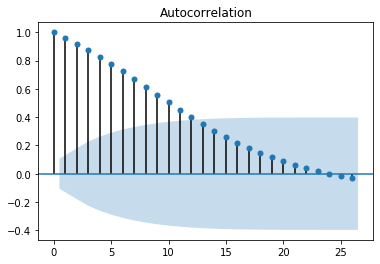

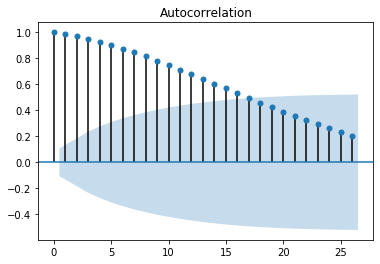

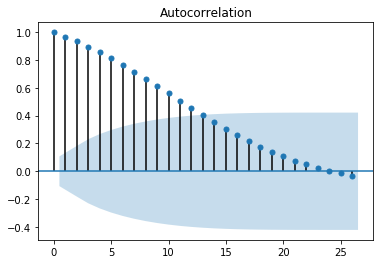

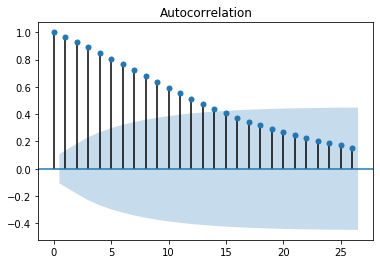

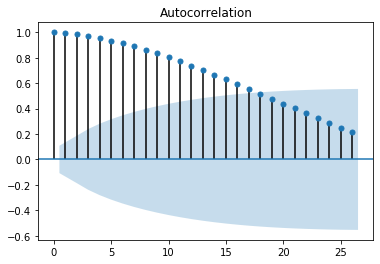

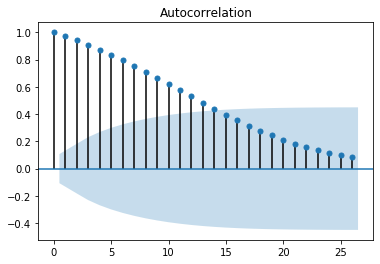

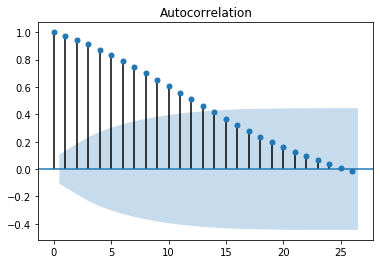

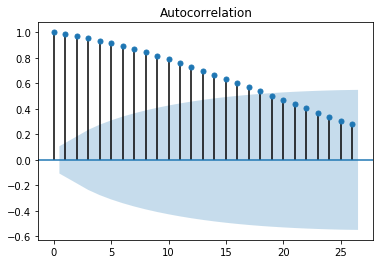

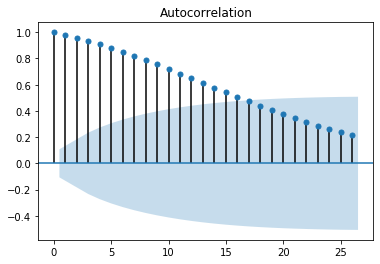

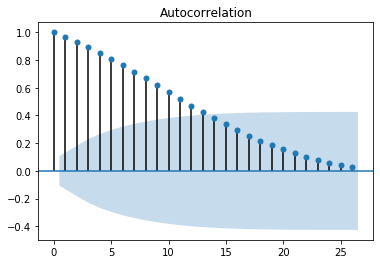

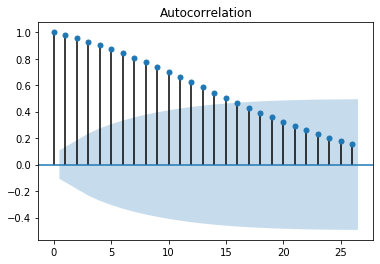

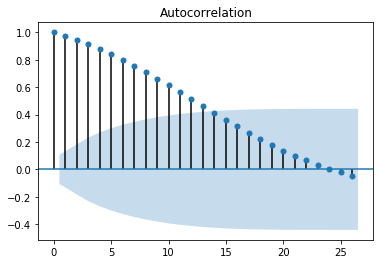

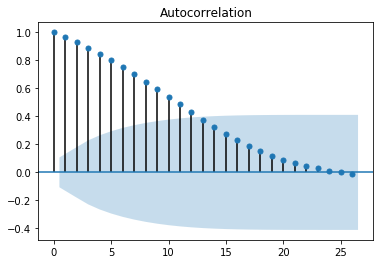

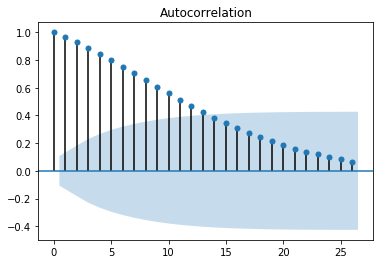

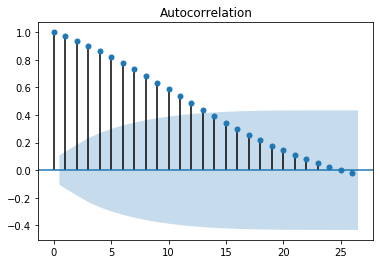

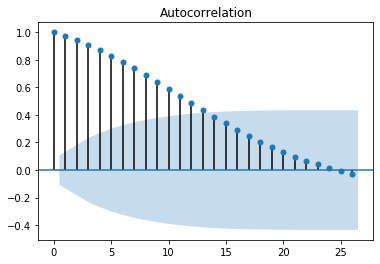

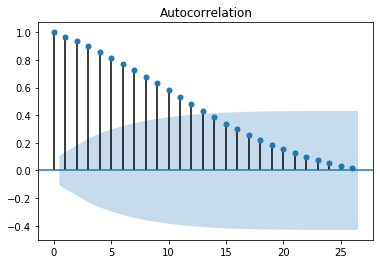

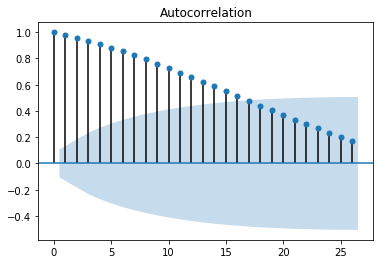

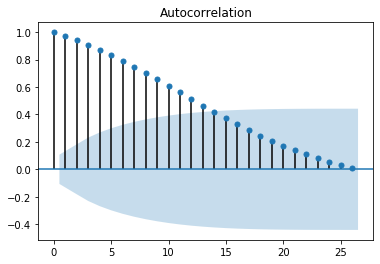

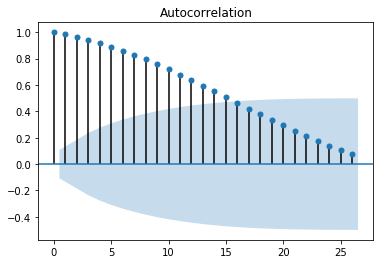

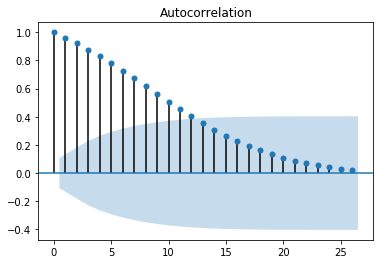

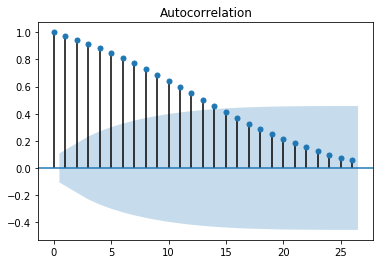

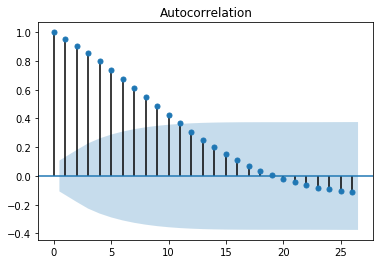

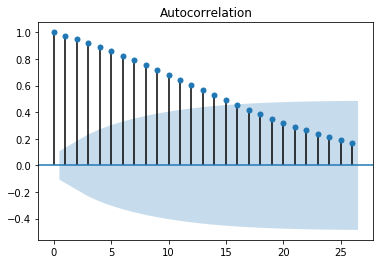

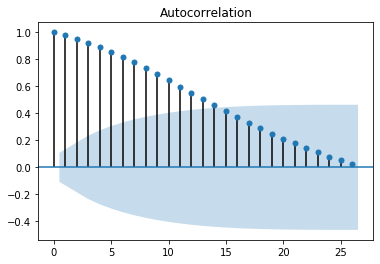

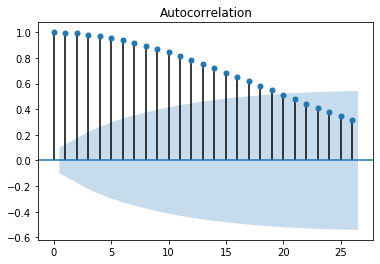

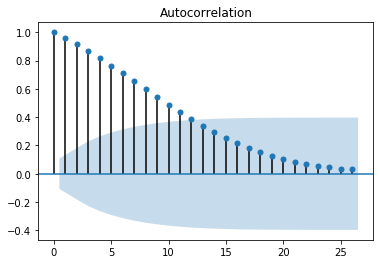

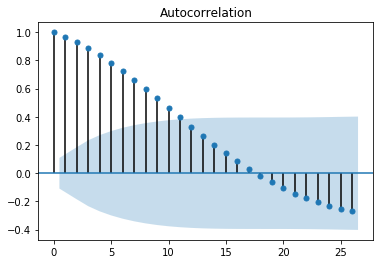

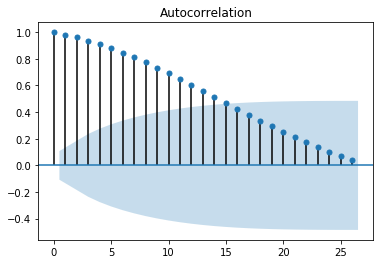

In [13]:
#Perform ACF for R0 value
for x in lst:
    tmp=rt_by_state[['date',x]]
    tmp=tmp[tmp[x].notnull()]
    plot_acf(tmp[x])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

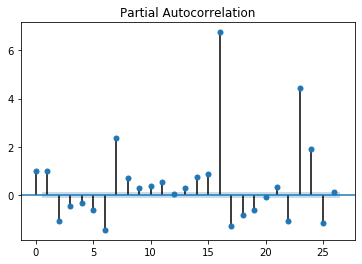

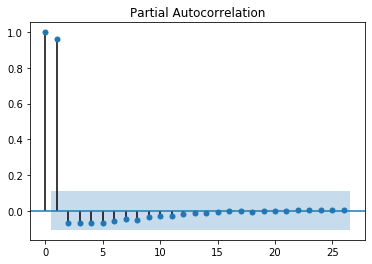

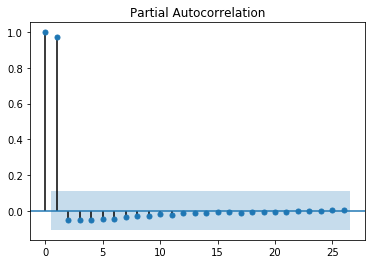

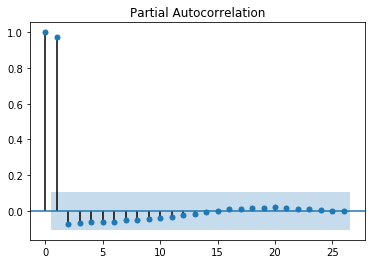

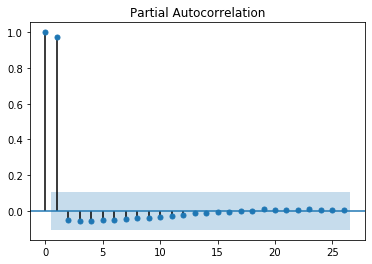

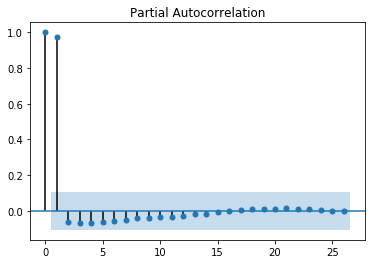

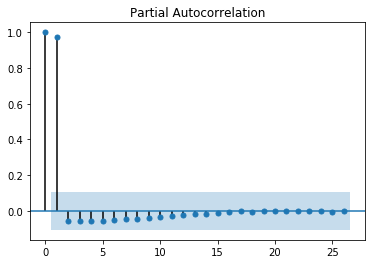

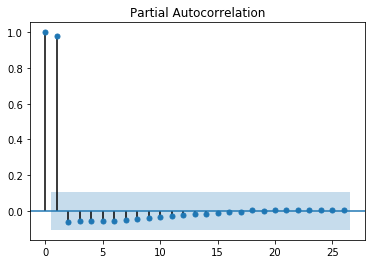

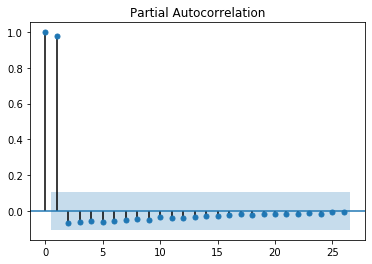

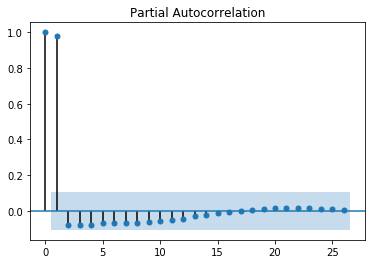

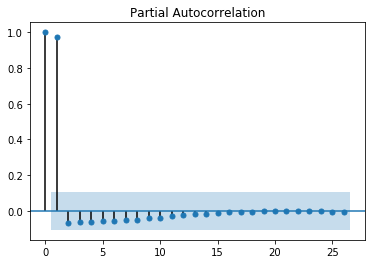

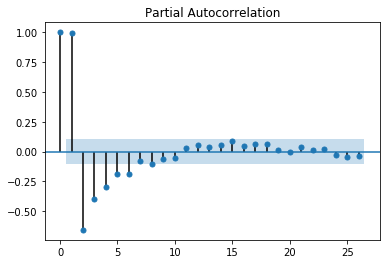

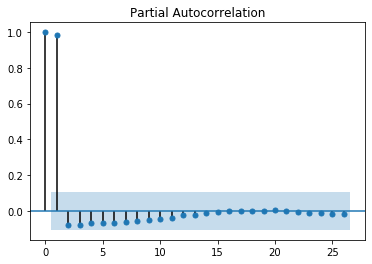

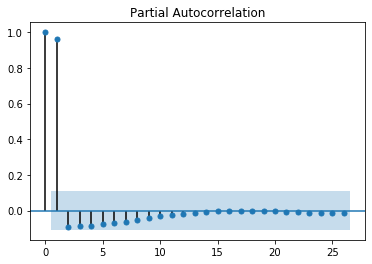

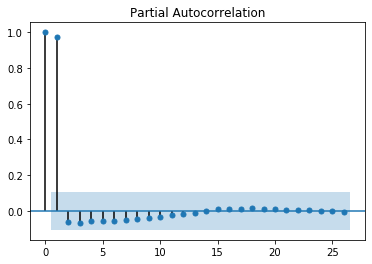

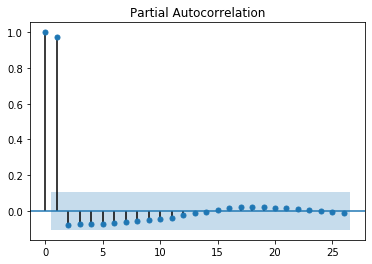

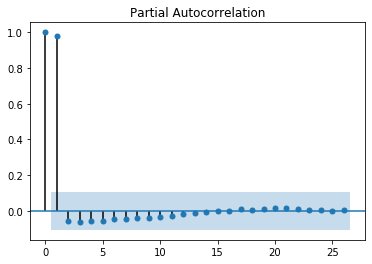

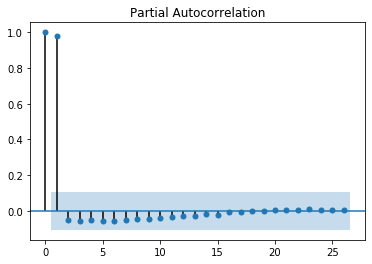

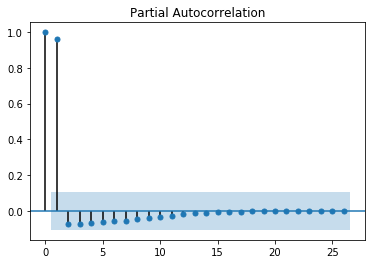

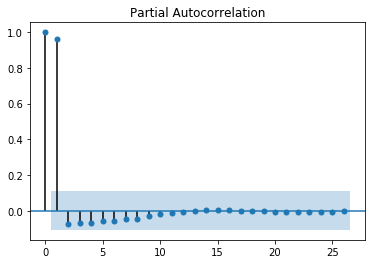

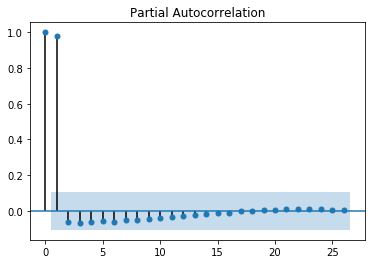

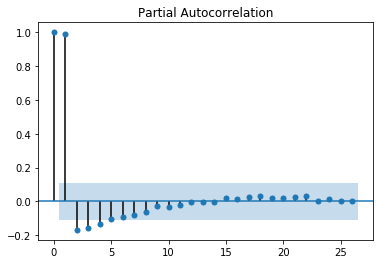

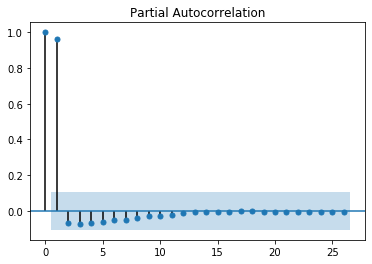

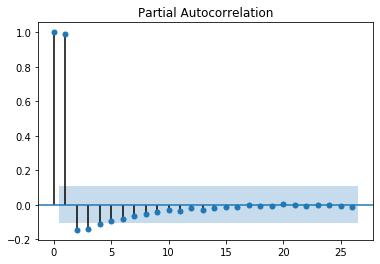

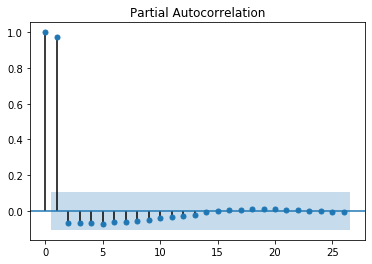

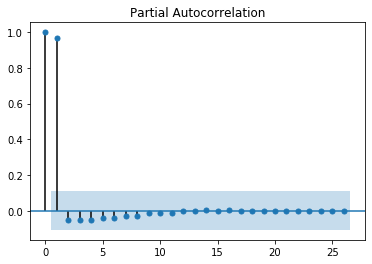

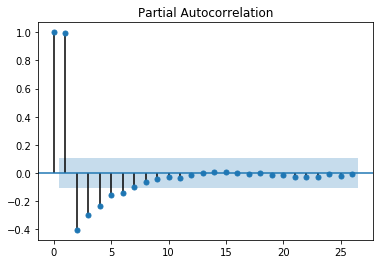

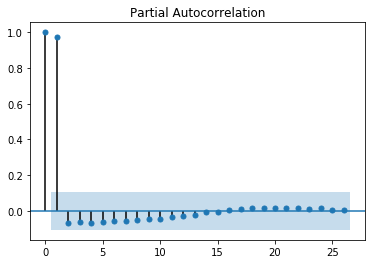

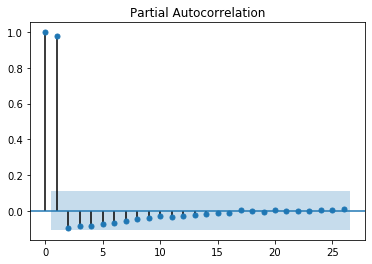

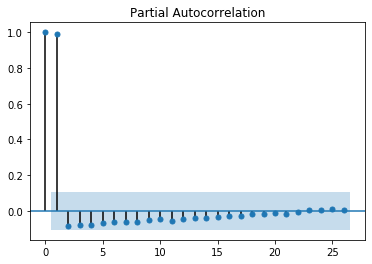

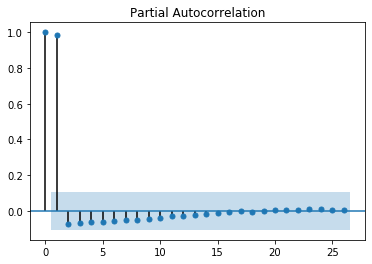

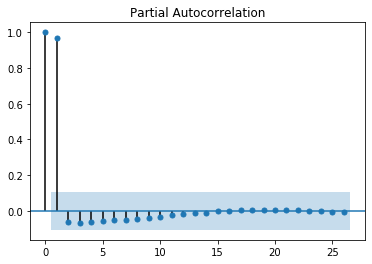

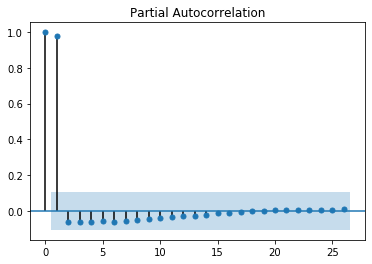

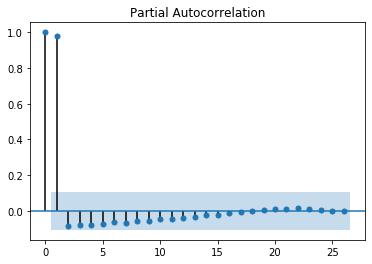

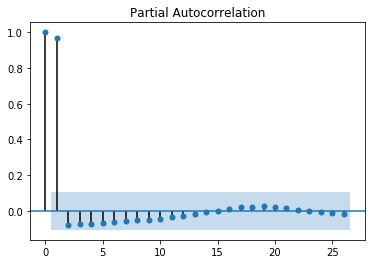

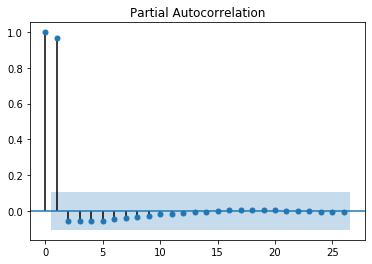

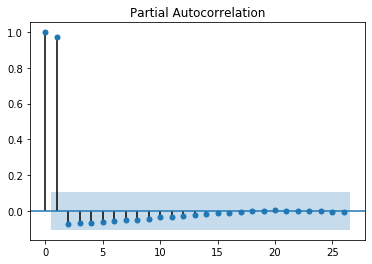

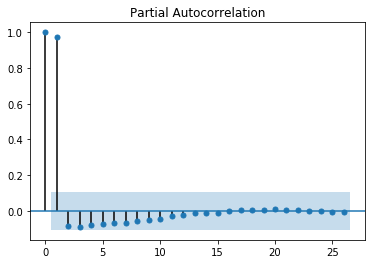

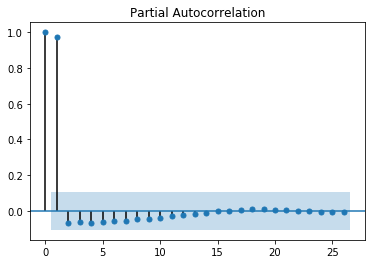

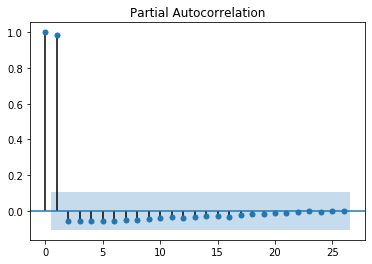

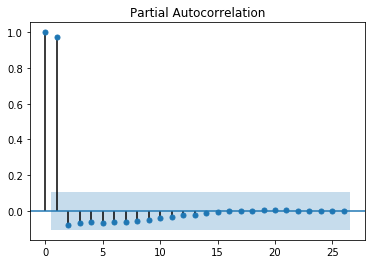

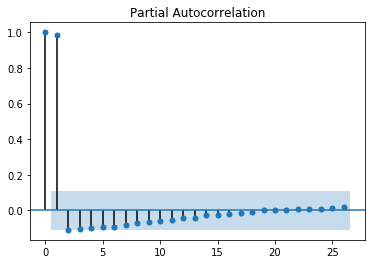

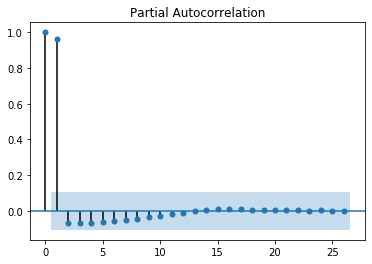

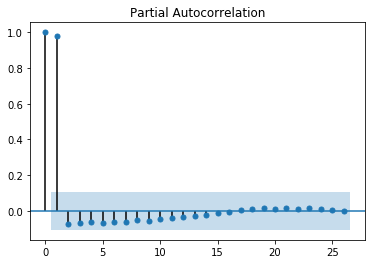

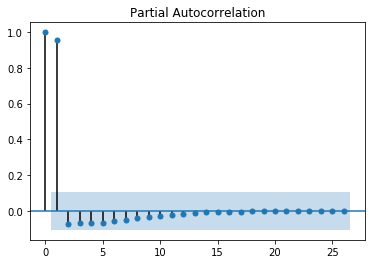

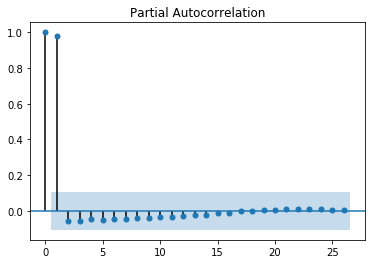

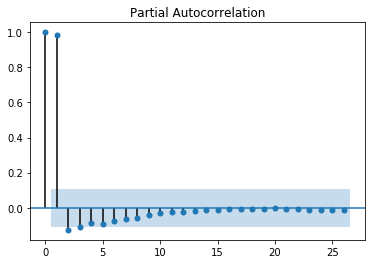

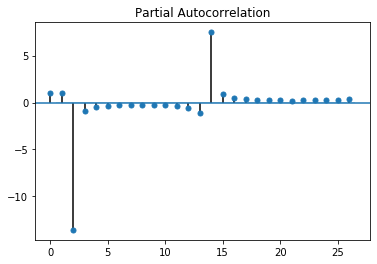

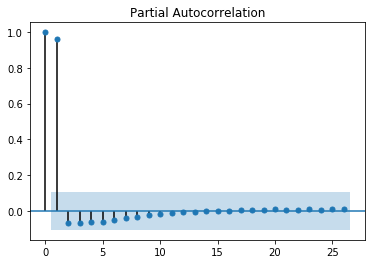

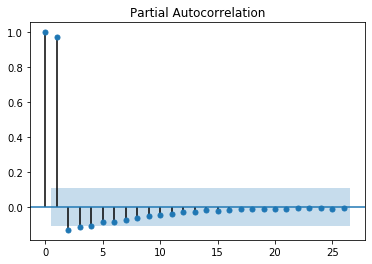

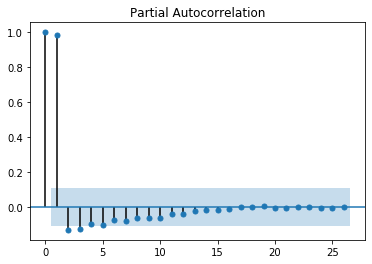

In [14]:
#Perform PACF for R0 value
for x in lst:
    tmp=rt_by_state[['date',x]]
    tmp=tmp[tmp[x].notnull()]
    plot_pacf(tmp[x])

In [15]:
#ARIMA(2,0,2) model is the best approach for predicting the next term R0 both due to PACF/ACF analysis and due to code running feasibility
rt_ar1_res=[]
for x in lst:
    tmp=rt_by_state[['date',x]]
    tmp=tmp[tmp[x].notnull()]
    mod = ARIMA(tmp[x], order=(2, 0, 2)).fit()
    rt_ar1_res.append(mod)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Li

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to co

In [16]:
Rt_predict=[]
Re_price_predict=[]
CPI_1mo_predict=[]
CPI_12mo_predict=[]
Ur_rate_predict=[]
for i in range(len(rt_ar1_res)):
    Rt_predict.append(rt_ar1_res[i].forecast(steps=5)[0][-1]) 
    Re_price_predict.append(res_Re_price[i].predict([[Rt_predict[i]]]))
    CPI_12mo_predict.append(res_CPI_12mo[i].predict([[Rt_predict[i]]]))
    CPI_1mo_predict.append(res_CPI_1mo[i].predict([[Rt_predict[i]]]))
    Ur_rate_predict.append(res_Ur_rate[i].predict([[Rt_predict[i]]]))
Re_price_predict=np.array(Re_price_predict).flatten().tolist()
CPI_1mo_predict=np.array(CPI_1mo_predict).flatten().tolist()
CPI_12mo_predict=np.array(CPI_12mo_predict).flatten().tolist()
Ur_rate_predict=np.array(Ur_rate_predict).flatten().tolist()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1541: RuntimeWarning: invalid value encountered in sqrt
  fcasterr = np.sqrt(sigma2 * np.cumsum(ma_rep ** 2))


In [17]:
combine_feb21['Rt_predict']=Rt_predict
combine_feb21['Re_price_predict']=Re_price_predict
combine_feb21['CPI_12mo_predict']=CPI_12mo_predict
combine_feb21['Ur_rate_predict']=Ur_rate_predict
combine_feb21.to_csv (r'combined_feb21_prediction.csv', index = False, header=True)